# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [1]:
# Импортируем базы данных, которые пригодятся в нашем исследование
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
# читаем файл users_behavior из папки /datasets/, указав в качестве разделителя знак табуляции ',', 
#  и сохраним результат в датафрейме data
data = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
# Посмотрим основную информацию датафрейма 
# и статистические данные, которые дают представление о распределение значений (округлив до сотых)
display(data.head(), data.info(), data.describe().round(2))
# Посмотрим кол-во дубликатов
print('Кол-во дубликатов:', data.duplicated().sum(), '\n')
# Проверим кол-во пропусков в столбцах датафрейма
print('Кол-во пропусков в столбцах\n', data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


None

,calls,minutes,messages,mb_used,is_ultra
count,3214.00,3214.00,3214.00,3214.00,3214.00
mean,63.04,438.21,38.28,17207.67,0.31
std,33.24,234.57,36.15,7570.97,0.46
min,0.00,0.00,0.00,0.00,0.00
25%,40.00,274.58,9.00,12491.90,0.00
50%,62.00,430.60,30.00,16943.24,0.00
75%,82.00,571.93,57.00,21424.70,1.00
max,244.00,1632.06,224.00,49745.73,1.00


Кол-во дубликатов: 0 

Кол-во пропусков в столбцах
 calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64


В нашем датафрейме 3214 строк, явные дубликаты и пропущенные значения в столбцах отсутсвуют, названия самих столбцов приведены к нижнему регистру: предобработка данных не понадобится. Относительно типа данных - во всех столбцах, кроме 'is_ultra' -вещественный тип, в столбце 'is_ultra' - целочисленный.

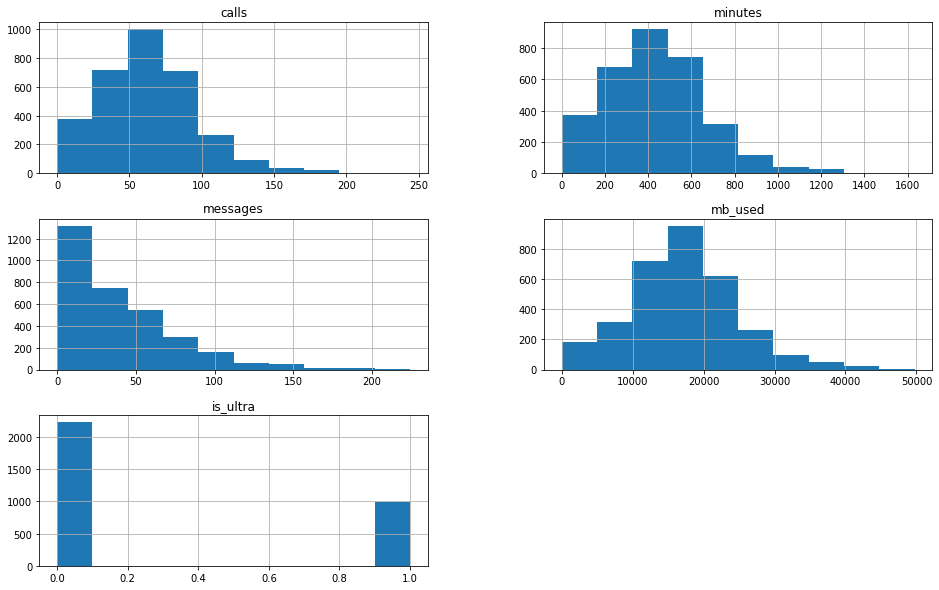

In [4]:
# построим общую гистограмму для всех столбцов таблицы (используем plt.show() для того, 
#             что бы не ввыводить на экран текстовую информацию перед таблицами)
data.hist(figsize=(16, 10))
plt.show()

По гистограммам можно сказать:
- В месяц в среднем совершается ~ до 120 звонком, с пиковыми показателями 50 - 70 звонком;
- Средняя продолжительность звонка в 438 минуты близка к медианным показателями в 430 минут. Основной диапозон времени разговоров в месяц от нуля до 800 минут.
- Большая часть клиентов отправляет до 20 смс в месяц, и в целом клиенты не используют более 90 смс за этот период.
- Основная часть людей тратят от 6 тыс до 29 тыс мб за месяц, с пиковымыми показателями в 15-20 тыс мб.
- Клиентов с тарифом "смарт" более чем в 2 раза больше, чем клиентов "ультра".

0    2229
1     985
Name: is_ultra, dtype: int64


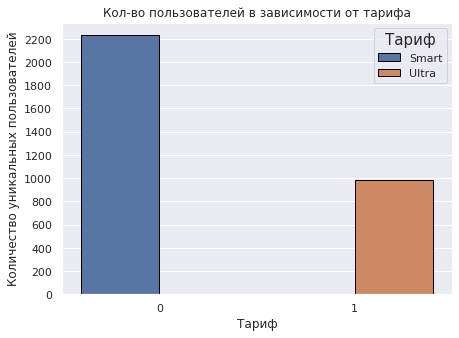

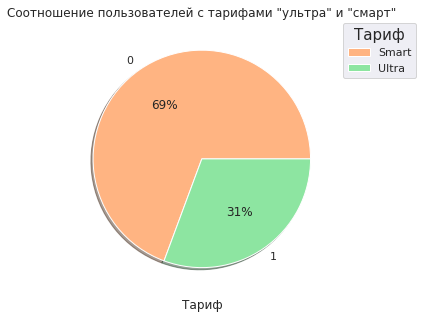

Соотношение тарифов: "Смарт": 0.69 
 "Ультра": 0.31


In [5]:
# Соотношение пользователей с тарифами "ультра" и "смарт"


# Посмотрим на кол-во пользователей по каждому тарифу
print(data['is_ultra'].value_counts())

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(data=data, x='is_ultra', ec='black', hue='is_ultra')
plt.title('Кол-во пользователей в зависимости от тарифа')
plt.xlabel('Тариф')
plt.ylabel('Количество уникальных пользователей')
plt.yticks(ticks=np.arange(0,2400,200))
legend = plt.legend(['Smart','Ultra'], title = "Тариф", title_fontsize = 15)
plt.show()

# Посмотрим на круговую диаграмму
colors = sns.color_palette('pastel')[1:5]
data.groupby(['is_ultra']).count() .plot(kind='pie', y='calls',
  autopct='%1.0f%%', colors=colors, shadow=True)
plt.title('Соотношение пользователей с тарифами "ультра" и "смарт"')
plt.xlabel('Тариф')
plt.ylabel('')
legend = plt.legend(['Smart','Ultra'], title = "Тариф", title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

# Смотрим соотношение
print('Соотношение тарифов: "Смарт":', 
     round(len(data.query('is_ultra == 0')) / data['is_ultra'].count(),2), '\n',
     '"Ультра":', round(len(data.query('is_ultra == 1')) / data['is_ultra'].count(),2))

69 % занимает доля клиентов "Смарт" (2229 человек) и 31% на тариф "Ультра" (985 человек)

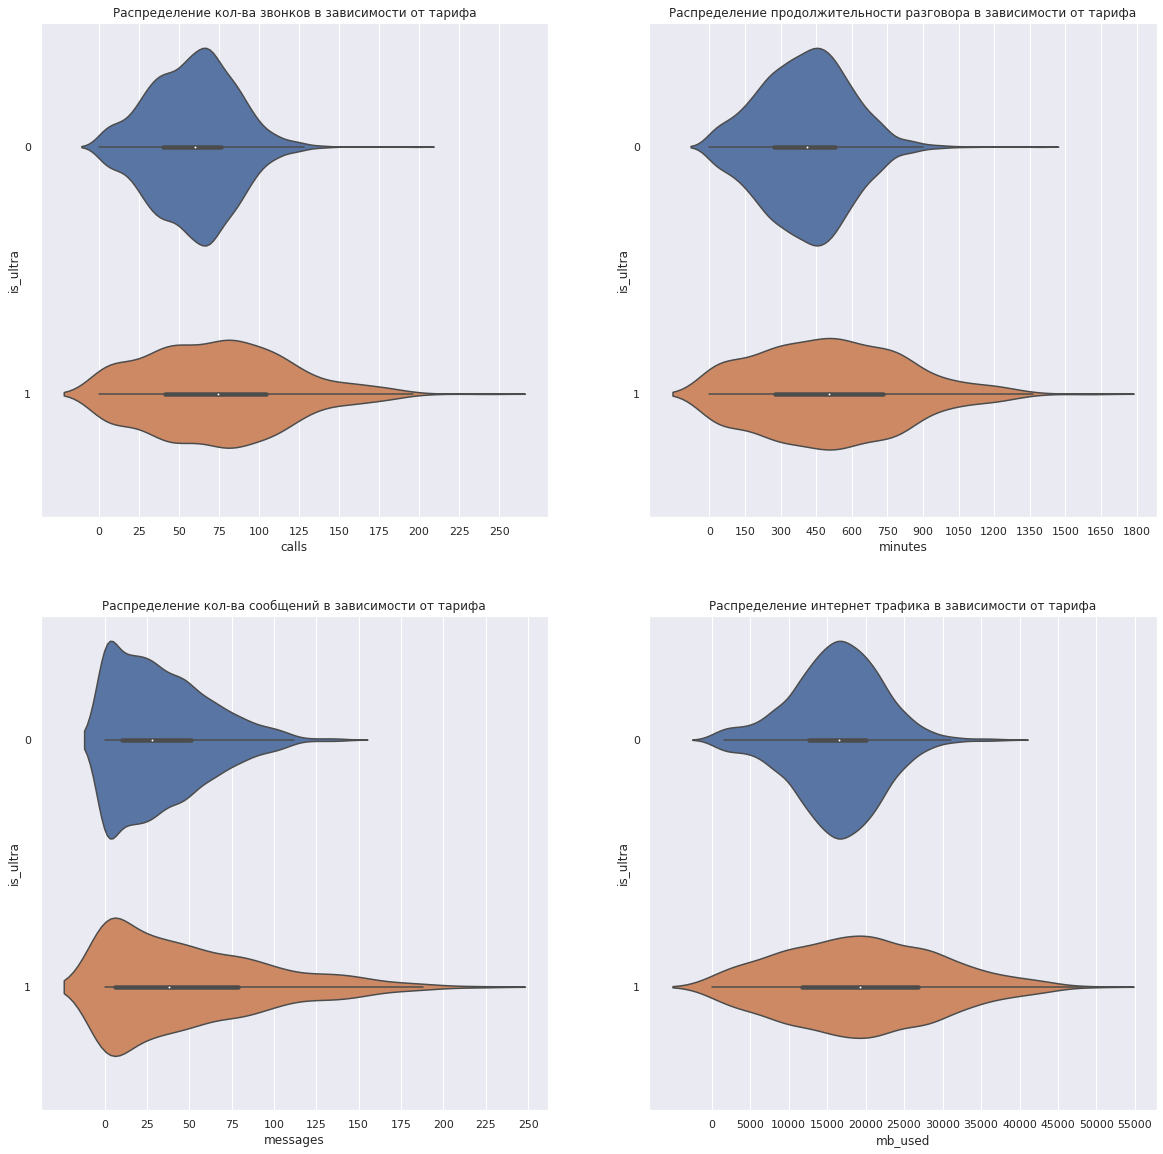

In [6]:
# Построим график типа "виолончельный ключ", на котором мы видим и гисстограмное распределение и диапозон размаха
sns.set(rc={'figure.figsize':(20,20)})
fig, axes = plt.subplots(2,2) # сделаем разбивку на 4 графика для каждого параметра и тарифа

# Для кол-ва звонков
axes[0,0].set_title('Распределение кол-ва звонков в зависимости от тарифа')
axes[0,0].set_xticks(ticks=np.arange(0,260,25))
sns.violinplot(ax=axes[0,0], data=data, x='calls', y='is_ultra', orient='h')

# Для продолжительности звонка
axes[0,1].set_title('Распределение продолжительности разговора в зависимости от тарифа')
axes[0,1].set_xticks(ticks=np.arange(0,1900,150))
sns.violinplot(ax=axes[0,1], data=data, x='minutes', y='is_ultra', orient='h')

# Для кол-ва сообщений
axes[1,0].set_title('Распределение кол-ва сообщений в зависимости от тарифа')
axes[1,0].set_xticks(ticks=np.arange(0,260,25))
sns.violinplot(ax=axes[1,0], data=data, x='messages', y='is_ultra', orient='h')

# Для интернет трафика
axes[1,1].set_title('Распределение интернет трафика в зависимости от тарифа')
axes[1,1].set_xticks(ticks=np.arange(0,60000,5000))
sns.violinplot(ax=axes[1,1], data=data, x='mb_used', y='is_ultra', orient='h')

plt.show()

In [7]:
# Посмотрим на статистические данные столбцов каждого из тарифов, которые дают представление о распределение значений
print('Smart:')
display(data.loc[(data['is_ultra'] == 0)].describe())
print('Ultra:')
display(data.loc[(data['is_ultra'] == 1)].describe())

Smart:


,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


Ultra:


,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


Как мы видим по графикам и статистическим данным для тарифа "Ультра" характерны более широкие диапозоны (ящичковая диаграмма) параметров в месяц (кол-во звонков и их продолжительность, кол-во смс и потребляемого интернет трафика). При этом для каждого тарифа все параметры, кроме "сообщений", симетрично распределены, только для тарифа "Ультра" распределение более плавное и равномерное, у "Смарт" агресивнее выделяются пиковые значения. "Усы" за правые квантили у "Ультры" примерно в полтора раза дальшу уходят, чем у "Смарт". В наших данных отсутсвуют выбросы, которые могут повлиять на дальнейшее исследование и обучение.

Таким образом можно сделать вывод, что тариф "Ультра" используют более активные "сотовые" пользователи.

,calls,minutes,messages,mb_used
calls,1.000000,0.972654,0.208789,0.357349
minutes,0.972654,1.000000,0.203746,0.341639
messages,0.208789,0.203746,1.000000,0.146499
mb_used,0.357349,0.341639,0.146499,1.000000


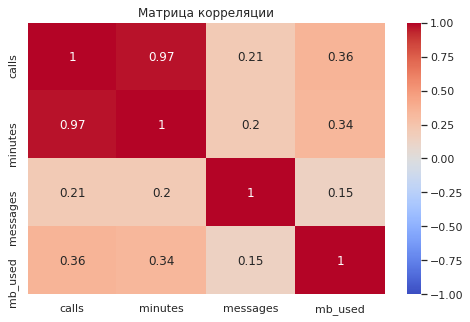

In [8]:
# Воспользуемся методом корреляции и хитмепом наблюдения зависимостей для "Смарт"

# Нам нужен список с параметрами для проверки: кол-во и время звонков, кол-во смс, интернет трафик
corr_columns = ['calls', 'minutes', 'messages', 'mb_used']
corr_matrix = data.loc[(data['is_ultra'] == 0), corr_columns].corr()
# выводим матрицу корреляции
display(corr_matrix)

# Визуализируем
plt.figure(figsize = (8, 5))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title('Матрица корреляции')
plt.show()

,calls,minutes,messages,mb_used
calls,1.000000,0.988235,0.087691,0.176856
minutes,0.988235,1.000000,0.083000,0.178003
messages,0.087691,0.083000,1.000000,0.173710
mb_used,0.176856,0.178003,0.173710,1.000000


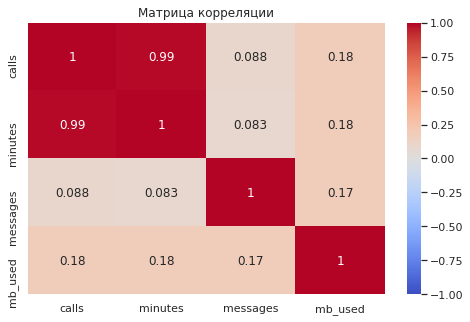

In [10]:
# Воспользуемся методом корреляции и хитмепом наблюдения зависимостей для "Ультра"

# Нам нужен список с параметрами для проверки: кол-во и время звонков, кол-во смс, интернет трафик
corr_columns = ['calls', 'minutes', 'messages', 'mb_used']
corr_matrix = data.loc[(data['is_ultra'] == 1), corr_columns].corr()
# выводим матрицу корреляции
display(corr_matrix)

# Визуализируем
plt.figure(figsize = (8, 5))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title('Матрица корреляции')
plt.show()

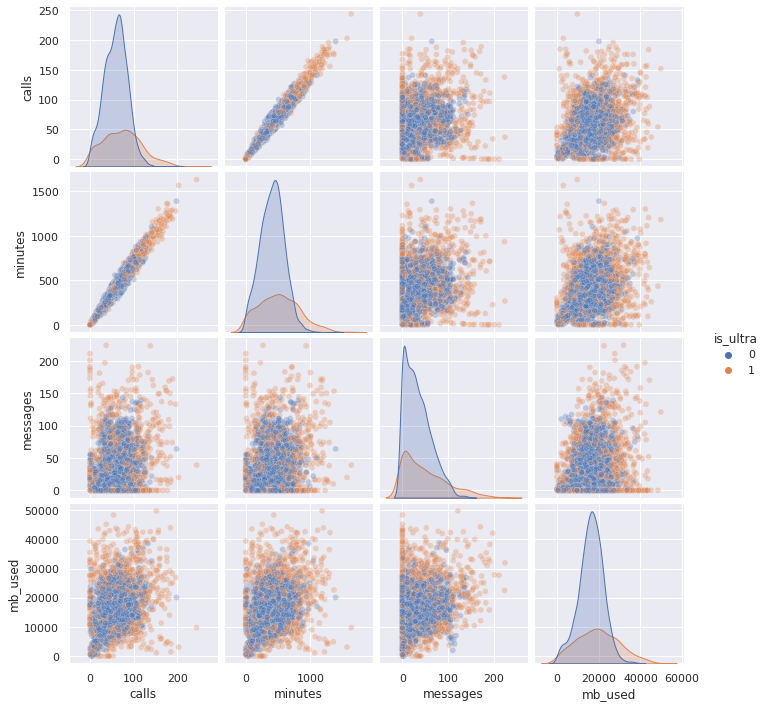

In [12]:
# Построим pair.plot для отображения зависимостей
sns.pairplot(data, diag_kind='kde', hue='is_ultra', plot_kws={'alpha': 0.3})
plt.show()

Что мы видим:
Для обоих тарифов максимальная линейная зависимость между кол-вом звонков и их продолжительностью, корреляция положительная и достигает почти единицы. Для тарифа "Смарт" средняя положительная зависимость между потребляемым интернет трафиком и кол-вом/ продолжительностью звонков. Так же для "Смарт" есть незначительная положительная зависимость между кол-вом смс и остальными параметрами (корреляция на уровне 0.15-0.21). Для тарифа "Ультра" присутсвует незначительная положительная зависимость между интерент трафиком остальными параметрами (корреляция 0.17-0.18).

## Разбейте данные на выборки

In [13]:
# Объявим переменные признака и цели
features = data.drop(['is_ultra'], axis=1) # записываем признаки для обущающей модели
target = data['is_ultra'] # записываем цель (задача классификации)

С помощью функции train_test_split (от англ. «разделить на обучающую и тестовую») разобьем датасет на обучающую, валидационную и тестовую выборки. Спрятанной тестовой выборки нет. Исходные данные разделим в соотношении 3:1:1

In [14]:
#  Обучающая выборка
# В размер валидационной выборки (test_size) мы пишем 0,4 (выражается в долях — от 0 до 1), т.к. 
# соотношении 3:1:1 и на валидационная и тестовая выборку отправляем 40% исходных данных

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

# Смотрим размер выборки 
print(features_train.shape)
print(target_train.shape)

(1928, 4)
(1928,)


In [15]:
#  Валидационная и тестовая выборки
# test_size = 0.5, выборки делим пополам

features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345)

# Смотрим размер выборки 
print('Размер валидационной выборки:\n', features_valid.shape, '\n', target_valid.shape)
print('')
print('Размер тестовой  выборки:\n', features_test.shape, '\n', target_test.shape)

Размер валидационной выборки:
 (643, 4) 
 (643,)

Размер тестовой  выборки:
 (643, 4) 
 (643,)


Мы с вами разбили данные на обучающую, валидационную и тестовую выборки. На обучение ушло 1928 записей, на валидационную и тестовую по 643 записи для каждой выборки соответсвенно.

## Исследуйте модели

Исследуем качество разных моделей, выберем оптимальные гиперпараметры.

В качестве моделей буем рассматривать:
- Решающее дерево (Decision Tree Classifier)

это структура данных для классификации деревом решений. Импортируем её из библиотеки:
`from sklearn.tree import DecisionTreeClassifier`

- Cлучайный лес (RandomForestClassifier)

Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования. Случайный лес помогает улучшить результат предсказания и избежать переобучения. В библиотеке sklearn алгоритм случайного леса RandomForestClassifier находится в модуле  sklearn.ensemble (от фр. «вместе»). Импортируем его:
`from sklearn.ensemble import RandomForestClassifier`

- Логистическая регрессия (Logistic Regression)

Логистическая регрессия применяется для прогнозирования вероятности возникновения некоторого события по значениям множества признаков.
Модель LogisticRegression лежит в модуле sklearn.linear_model (от англ. «линейная модель») библиотеки sklearn. Импортируем его:
`from sklearn.linear_model import LogisticRegression`

In [16]:
# Решающее дерево 

best_model = None
best_result = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучим модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучим модель
    predictions = model.predict(features_valid) # получим предсказания модели
    result = accuracy_score(target_valid,predictions) # посчитаем качество модели
    if result > best_result:
        best_depth= depth # сохраним наилучшее показание глубины дерева
        best_model = model # сохраним наилучшую модель
        best_result = result # сохраним наилучшее значение метрики accuracy на валидационных данных
        
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print('')
print('Лучшая глубина дерева:', best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.7993779160186625

Лучшая глубина дерева: 7


In [17]:
# Cлучайный лес

best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 50, 5):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучим модель 
# с заданным количеством деревьев
        model.fit(features_train, target_train) # обучим модель на тренировочной выборке
        result = model.score(features_valid, target_valid) # посчитаем качество модели на валидационной выборке
        if result > best_result:
            best_model = model # сохраним наилучшую модель
            best_result = result # сохраним наилучшее значение метрики accuracy на валидационных данных
            best_est = est # сохраним наилучшее показания количества деревьем
            best_depth = depth # сохраним наилучшее показание глубины дерева

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print('')
print('Лучшая глубина дерева:', best_depth)
print('')
print('Лучшее показания количества деревьев:', best_est)

Accuracy наилучшей модели на валидационной выборке: 0.8133748055987559

Лучшая глубина дерева: 9

Лучшее показания количества деревьев: 10


In [18]:
# Логистическая регрессия

model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) # Алгоритм 'lbfgs' строит модель,
# Гиперпараметром max_iter задаётся максимальное количество итераций обучения
model.fit(features_train, target_train) # обучаем модель
predictions = model.predict(features_valid)  # получим предсказания модели на валидационной выборке
accuracy = accuracy_score(predictions, target_valid) # посчитаем качество модели
print('Accuracy наилучшей модели на валидационной выборке:', accuracy)

Accuracy наилучшей модели на валидационной выборке: 0.6842923794712286


**Вывод:**

Лучшей обучающей моделью показал себя:

`Cлучайный лес (RandomForestClassifier)`
- Отношение числа правильных ответов к размеру валидационно выборки равно 0,8134; при следующих гиперпараметрах: глубина дерева равная 9, а количество деревьев равно 10.

На втором месте

`Решающее дерево (Decision Tree Classifier)`
- Accuracy лучшей модели: 0,7994 при глубине дерева равной 7

*Для этих двух моделей с помощью функции мы подбрали лучшие показатиели глубины дерева и кол-ва деревьев для RandomForestClassifier.*

На третьем месте

`Логистическая регрессия (Logistic Regression)`
- Accuracy наилучшей модели на валидационной выборке: 0.6843

## Проверьте модель на тестовой выборке

Так как лучшей моделью оказался "Случайный лес" с точностью в 0,8134, то тестовую выборку будем проводить на нем

In [19]:
# Проверим модель на тестовой выборке
model = RandomForestClassifier(random_state=12345, n_estimators = 9, max_depth = 7).fit(features_train, target_train)
predictions_test = model.predict(features_test)
result_test = accuracy_score(predictions_test, target_test)
print('Accuracy RandomForestClassifier тестовая выборка:', result_test)


Accuracy RandomForestClassifier тестовая выборка: 0.7962674961119751


**Вывод**

Точность на тестовой выборке равна 0,7963, что чуть хуже, чем на валидацинной выборке, но близка к ее результам в 0,8134.

Точность примененного метода более 0,75, что может сказатьнам о том, что модель обучения применена успешно.

## (бонус) Проверьте модели на адекватность

Для проверки используем модель `DummyClassifier`.

In [20]:
model = DummyClassifier(strategy='most_frequent', random_state=12345)
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid)
print('Accuracy DummyClassifier:', result)
print('')
print('Accuracy RandomForestClassifier тестовая выборка:', result_test)

Accuracy DummyClassifier: 0.6842923794712286

Accuracy RandomForestClassifier тестовая выборка: 0.7962674961119751


Мы можем сделать вывод, что модель адекватна и эффективна, так как точность модели DummyClassifier ниже, чем у модели RandomForestClassifier.

# Вывод

Мы просмотрели наш датафрейм по двум новым тарифам "Смарт" и "Ультра" оператор мобильной связи «Мегалайн». Нам была предоставлена информация без каких-либо дубликатов, пропусков и выбросов по 3214 пользователям, из которых 69 % занимает доля клиентов "Смарт" (2229 человек) и 31% на тариф "Ультра" (985 человек). Мы построили систему, способную проанализировать поведение клиентов и предложить новым пользователям данные тарифы. Мы проверили 3 модели для задачи классификации, которые определят подходящий тариф. С помощью функции train_test_split разделили датасет на обучающую, валидационную и тестовую выборки. Спрятанной тестовой выборки у нас не было и поэтому исходные данные разделили в соотношении 3:1:1 (1928, 643 и 643 записи соответсвенно). 

Проверили следующик модели: 
- Решающее дерево (Decision Tree Classifier), использовали гиперпараметры: глубина дерева и псевдослучайность («случайное состояние»).)
- Cлучайный лес (RandomForestClassifier), гиперпараметры: глубина дерева, кол-во деревьев, псевдослучайность
- Логистическая регрессия (Logistic Regression), гиперпараметры: максимальное количество итераций обучения и алгоритм построения модели.

Опытным путем выяснили, что в нашем случае самая большая точность у обученной модели Cлучайный лес, Accuracy валидациооной выборки более 0,81. При проверке на тестовой выборке показатели были чуть хуже: 0,796. Адекватность нашей модели проверили и подтвердили с помощью метода DummyClassifier, точность данного метода ~0,6843, что меньше, чем у нашей модели.

Таким образом мы построили модель для задачи классификации, которая может предложить пользователям новый тариф: «Смарт» или «Ультра».